In [9]:
import numpy as np
import xtrack as xt
import xobjects as xo
import xpart as xp
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy import constants 


line = xt.Line.from_json('sps.json')
particle_ref=line.particle_ref

line.build_tracker()
#line.freeze_longitudinal()
# line.optimize_for_tracking()

twiss=line.twiss()

clight=constants.speed_of_light
circumference = line.get_length()


#%%
###################
# Linear Transfer #
###################

qx=twiss['qx']
qy=twiss['qy']
dqx=twiss['dqx']
dqy=twiss['dqy']
circumference=twiss['s'][-1]
# beta_x=twiss['betx'][-1]
# beta_y=twiss['bety'][-1]

qs=twiss['qs']
bets=twiss['betz0']
voltage_rf=7*1e6
frequency=201.8251348335775*1e6
lag_rf=180
momentum_compaction_factor=twiss['momentum_compaction_factor']
slip_factor=['slip_factor']

# qs=0.0131
# bets=0.063/2e-4

#at interaction points: #from https://anaconda.org/petrenko/li_like_ca_in_sps/notebook
beta_x  =  54.614389 # m
beta_y  =  44.332517 # m
alpha_x = -1.535235
alpha_y =  1.314101

Dx  =  2.444732 # m
Dpx =  0.097522


Dy  =  0.0 # m
Dpy =  0.0

#index of gamma factory along SPS line: 16675

arc = xt.LineSegmentMap(
        qx=qx, qy=qy,
        dqx=0, dqy=0,
        length=circumference,
        alfx=alpha_x,
        alfy=alpha_y,
        betx=beta_x,
        bety=beta_y,
        
        dx=Dx,
        dpx=Dpx,
        dy=Dy,
        dpy=Dpy,
        qs=qs,
        bets=bets,
        # voltage_rf=voltage_rf,
        # lag_rf=lag_rf,
        # frequency_rf=frequency,
        # momentum_compaction_factor=momentum_compaction_factor,
        # longitudinal_mode = 'nonlinear',

        )


Loading line from dict:   0%|          | 0/38786 [00:00<?, ?it/s]

Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


In [10]:
from ion_properties import ions,lead,calcium,xenon,xenon2nd


In [11]:
ions_list=lead,xenon,xenon2nd,calcium

for ion in [lead]:# Ion properties:
        q0 = ion.q0
        mass0 = ion.mass0
        print('mass0',mass0*1e-9)

        # gamma = 96.08563421444993
        # gamma =96.08823512129918
        gamma = ion.gamma_rel4
        #gamma = 205.62
        print(gamma)
        beta= np.sqrt(1-1/(gamma*gamma))
        p0c = mass0*gamma*beta #eV/c

        bunch_intensity = ion.Intensity

        particle_ref = xp.Particles(p0c=p0c, mass0=mass0, q0=q0,gamma0=gamma)

        line.particle_ref=particle_ref

        nemitt = 1.5e-6 # m*rad (normalized emittance)
        sigma_z = 0.063 # m

        # emittance=nemitt/(beta*gamma)

        num_particles=int(5e4)

        line_arc=xt.Line(
                elements=[arc])
        line_arc.build_tracker()

        particles = xp.generate_matched_gaussian_bunch(
                num_particles=num_particles,
                total_intensity_particles=bunch_intensity,
                nemitt_x=nemitt, nemitt_y=nemitt, sigma_z=sigma_z,
                particle_ref=particle_ref,
                line=line_arc,
                #ngine="single-rf-harmonic",        
                )
        particles._init_random_number_generator()
        
        particles0=particles.copy()

        # sigma_dp=2e-4  
        sigma_dp=np.std(particles.delta)
        print('sigma_dp',sigma_dp*1e4)
        sigma_dp=2e-4 
        ##################
        # Laser Cooler #
        ##################

        #laser-ion beam collision angle
        theta_l = 2.6*np.pi/180 # rad
        nx = 0; ny = -np.sin(theta_l); nz = -np.cos(theta_l)

        # Ion excitation energy:
        ion_excited_lifetime=ion.excited_lifetime
        hw0 = ion.hw0 # eV
        hc=constants.hbar*clight/constants.e # eV*m (ħc)
        lambda_0 = 2*np.pi*hc/hw0 # m -- ion excitation wavelength

        lambda_l = ion.lambda_l


        # Shift laser wavelength for fast longitudinal cooling:
        #lambda_l = lambda_l*(1+1*sigma_dp) # m

        laser_frequency = clight/lambda_l # Hz
        sigma_w = 2*np.pi*laser_frequency*sigma_dp
        #sigma_w = 2*np.pi*laser_frequency*sigma_dp/2 # for fast longitudinal cooling

        sigma_t = 1/sigma_w # sec -- Fourier-limited laser pulse
        print('Laser pulse duration sigma_t = %.2f ps' % (sigma_t/1e-12))
        print('Laser wavelength = %.2f nm' % (lambda_l/1e-9))

        laser_waist_radius = 1.3e-3 #m
        laser_energy = 5e-3
           
        print('Laser pulse duration sigma_t = %.2f ps' % (sigma_t/1e-12))
        
        laser_x = -0.9*1e-3

        GF_IP = xt.PulsedLaser(
                        laser_x=laser_x,
                        laser_y=0,
                        laser_z=0,
                        
                        laser_direction_nx = 0,
                        laser_direction_ny = ny,
                        laser_direction_nz = nz,
                        laser_energy         = laser_energy, # J
                        laser_duration_sigma = sigma_t, # sec
                        laser_wavelength = lambda_l, # m
                        laser_waist_radius = laser_waist_radius, # m
                        laser_waist_shift = 0, # m
                        ion_excitation_energy = hw0, # eV
                        ion_excited_lifetime  = ion_excited_lifetime, # sec                   
                        )

        # simulation parameters: simulate 10 s of cooling, and take data once every 100 ms
        max_time_s = 100
        int_time_s = 1
        T_per_turn = circumference/(clight*beta)
        num_turns = int(max_time_s/T_per_turn)
        save_interval = int(int_time_s/T_per_turn)


        # create a monitor object, to reduce holded data
        monitor = xt.ParticlesMonitor(start_at_turn=0, stop_at_turn=1,
                                n_repetitions=int(num_turns/save_interval),
                                repetition_period=save_interval,
                                num_particles=num_particles)
                                    
        line = xt.Line(
                elements=[monitor,GF_IP,arc])
        
        # line = xt.Line(
        #         elements=[monitor,arc])

        context = xo.ContextCpu(omp_num_threads=3)
        line.build_tracker(_context=context)

        line.track(particles, num_turns=num_turns,
                turn_by_turn_monitor=False,with_progress=True)

        # extract relevant values
        x = monitor.x[:,:,0]
        px = monitor.px[:,:,0]
        y = monitor.y[:,:,0]
        py = monitor.py[:,:,0]
        delta = monitor.delta[:,:,0]
        zeta = monitor.zeta[:,:,0]
        state = monitor.state[:,:,0]
        time = monitor.at_turn[:, 0, 0] * T_per_turn

        gamma_x=(1+alpha_x**2)/beta_x
        gamma_y=(1+alpha_y**2)/beta_y

        action_x = (gamma_x*(x-Dx*delta)**2 + 2*alpha_x*(x-Dx*delta)*(px-Dpx*delta)+ beta_x*(px-Dpx*delta)**2)
        action_y = (gamma_y*(y-Dy*delta)**2 + 2*alpha_y*(y-Dy*delta)*(py-Dpy*delta)+ beta_y*(py-Dpy*delta)**2)

        emittance_x_twiss=np.mean(action_x,axis=1)*gamma/2
        rms_dp_p=np.std(delta,axis=1)

        
        np.savez(f'results/counter_IBS/{ion.name}.npz', x=x, px=px, y=y, py=py, zeta=zeta, delta=delta,
                action_x=action_x,action_y=action_y,emittance_x=emittance_x_twiss,state=state, time=time,s_per_turn=T_per_turn)

mass0 193.75230630336
96.07863342564447
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
sigma_dp 2.001386527198448
Laser pulse duration sigma_t = 2.74 ps
Laser wavelength = 1031.80 nm
Laser pulse duration sigma_t = 2.74 ps
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/4337400 [00:00<?, ?it/s]

In [12]:
print(sigma_w*1e-12)

0.36511951294996187


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


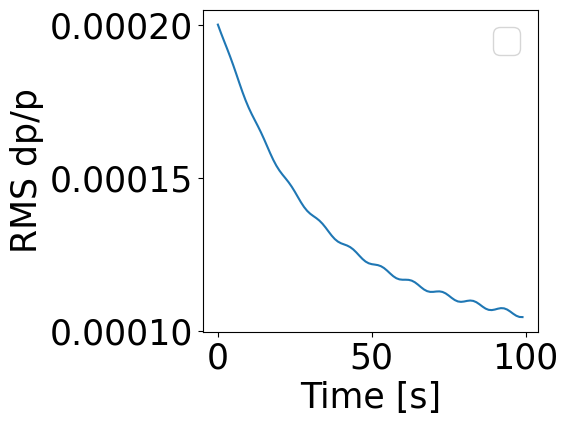

In [13]:
excited0=state[1,:]==2
fraction_excitation=sum(excited0)/len(excited0)
rms_dp_p = np.std(delta, axis=1)


plt.figure()
plt.plot(time, rms_dp_p)

plt.xlabel(r'Time [s]')
plt.ylabel(r'RMS dp/p')
plt.legend()
plt.tight_layout()
# plt.savefig('Transverse_laser_cooling_rates.png', dpi=300)
plt.show()

In [14]:
xenon.N_a/1e8

4.20195867

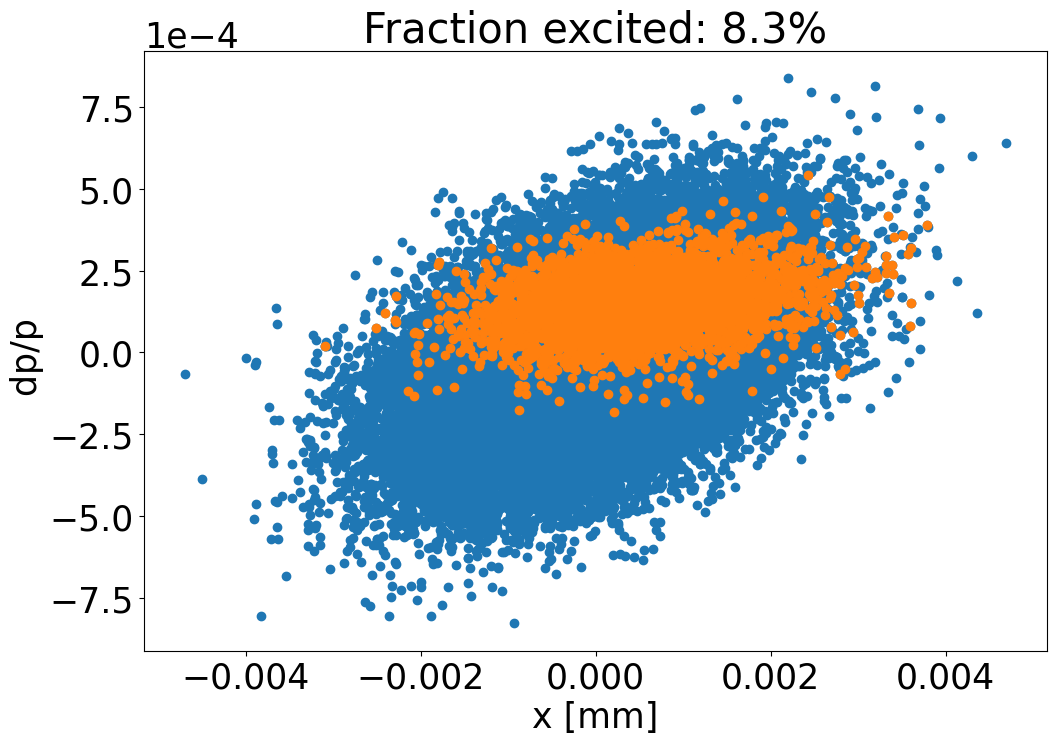

In [15]:
turn=1
excited=state==2
excited0=excited[turn,:]
fraction_excitation0 = sum(excited0)/len(excited0)*100


plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': 25})
plt.title(f'Fraction excited: {round(fraction_excitation0, 1)}%')

#plt.axvline(laser_x,color='red')
# plt.axvline(laser_x+laser_waist_radius,color='red')
# plt.axvline(laser_x-laser_waist_radius,color='red')

plt.scatter(x[turn],delta[turn])
plt.scatter(x[turn][excited0],delta[turn][excited0])
plt.xlabel('x [mm]')
plt.ylabel('dp/p ')
plt.tight_layout()
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
x_min, x_max = plt.xlim()
y_min, y_max = plt.ylim()
#plt.savefig('First_turn.eps', format='eps', dpi=300)
plt.show()

In [16]:
qs*100

0.6283858035603329